# **Load Dataset**

In [2]:
# Install the library that can handle multi-channel TIFF images
!pip install tifffile

In [3]:
!pip install tensorflow-io -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 20.0 MB/s eta 0:00:00


In [4]:
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import tifffile as tiff
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_io as tfio
import numpy as np
from matplotlib.colors import ListedColormap

/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_util8EndsWithESt17basic_string_viewIcSt11char_traitsIcEES4_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl8str_util9LowercaseB5cxx11ESt17basic_s

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_dir = '/content/drive/MyDrive/Cellula Technology/Water Segmentation/Water Segmentation.zip'
zip_ref = zipfile.ZipFile(zip_dir, 'r')
zip_ref.extractall('/content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset')
zip_ref.close()

In [5]:
main_dir = '/content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data'

In [6]:
# Get the paths to the image and mask directories
image_dir = os.path.join(main_dir, 'images')
mask_dir = os.path.join(main_dir, 'labels')

# **Data Preprocessing**

In [7]:
def count_images_in_directory(directory):
  total_images = 0
  for dirpath, dirnames, filenames in os.walk(directory):
    total_images += len(filenames)
  return total_images

In [8]:
print(f"Number of images: {count_images_in_directory(image_dir)}")
print(f"Number of masks: {count_images_in_directory(mask_dir)}")

Number of images: 306
Number of masks: 306


In [9]:
import os

# Data Cleaning: Ensure every image has a corresponding mask and vice-versa

# Set this to False to actually delete the files after verifying the dry run.
DRY_RUN = False # Run with True first!

if DRY_RUN:
    print("Starting Data Cleaning (DRY RUN)")
    print("This will only show which files WOULD be deleted.")
else:
    print("Starting Data Cleaning (DELETING FILES)")

# Get the list of filenames from both directories
try:
    image_filenames = os.listdir(image_dir)
    mask_filenames = os.listdir(mask_dir)
    print(f"Initial image count: {len(image_filenames)}")
    print(f"Initial mask count: {len(mask_filenames)}")
except FileNotFoundError as e:
    print(f"Error: A directory was not found. Please check your paths. Details: {e}")
    # Stop execution of this cell if paths are wrong
    raise

# Get the BASE names (without extensions) and put them in sets

image_basenames = {os.path.splitext(f)[0] for f in image_filenames}
mask_basenames = {os.path.splitext(f)[0] for f in mask_filenames}

# Find the base names that are common to both sets
common_basenames = image_basenames.intersection(mask_basenames)
print(f"\nFound {len(common_basenames)} base names with a matching image and mask.")

# Find the files to delete from the IMAGES folder
images_to_delete = []
for img_file in image_filenames:
    base_name = os.path.splitext(img_file)[0]
    if base_name not in common_basenames:
        images_to_delete.append(img_file)

# Find the files to delete from the LABELS (masks) folder
masks_to_delete = []
for mask_file in mask_filenames:
    base_name = os.path.splitext(mask_file)[0]
    if base_name not in common_basenames:
        masks_to_delete.append(mask_file)

# Perform the deletion (or print for dry run)
print("\n Actions to be taken ")

# Process images
if not images_to_delete:
    print("✅ All images have a corresponding mask.")
else:
    print(f"Found {len(images_to_delete)} images to delete:")
    for filename in images_to_delete:
        print(f"  - To Delete: {os.path.join(image_dir, filename)}")
        if not DRY_RUN:
            os.remove(os.path.join(image_dir, filename))

# Process masks
if not masks_to_delete:
    print("✅ All masks have a corresponding image.")
else:
    print(f"Found {len(masks_to_delete)} masks to delete:")
    for filename in masks_to_delete:
        print(f"  - To Delete: {os.path.join(mask_dir, filename)}")
        if not DRY_RUN:
            os.remove(os.path.join(mask_dir, filename))

if not DRY_RUN:
    print("\nFile deletion complete.")

# Verify the final counts
final_image_count = len(os.listdir(image_dir))
final_mask_count = len(os.listdir(mask_dir))

print("\n--- Verification ---")
print(f"Final number of images: {final_image_count}")
print(f"Final number of masks: {final_mask_count}")

if final_image_count == final_mask_count and final_image_count == len(common_basenames):
    print("✅ Success! The number of images and masks now match.")
else:
    print("⚠️ Counts do not match or cleaning was not performed (check DRY_RUN setting).")

Starting Data Cleaning (DELETING FILES)
Initial image count: 306
Initial mask count: 306

Found 306 base names with a matching image and mask.

 Actions to be taken 
✅ All images have a corresponding mask.
✅ All masks have a corresponding image.

File deletion complete.

--- Verification ---
Final number of images: 306
Final number of masks: 306
✅ Success! The number of images and masks now match.


In [10]:
print(f"Number of images: {count_images_in_directory(image_dir)}")
print(f"Number of masks: {count_images_in_directory(mask_dir)}")

Number of images: 306
Number of masks: 306


# Data Visualization

To make water pop, we can use a spectral index. The most common one for water is the **Normalized Difference Water Index (NDWI)**.
It uses the **Green band** and the **Near-Infrared (NIR)** band in a simple formula:

                                            NDWI = (Green - NIR) / (Green + NIR)

Let's think about what this does:

🟥 For a Water Pixel: 🟥

Green has a medium value, while NIR is very low (absorbed).

So, (Medium - Low) / (Medium + Low) results in a **high positive value**.

🟥 For a Land/Vegetation Pixel: 🟥

Green has a medium value, but NIR is very high (reflected).

So, (Medium - High) / (Medium + High) results in a **strong negative value**.

By calculating this for every pixel, we can create a new image where water is very bright and everything else is very dark.

Displaying True Color vs. NDWI vs. Ground Truth Mask...


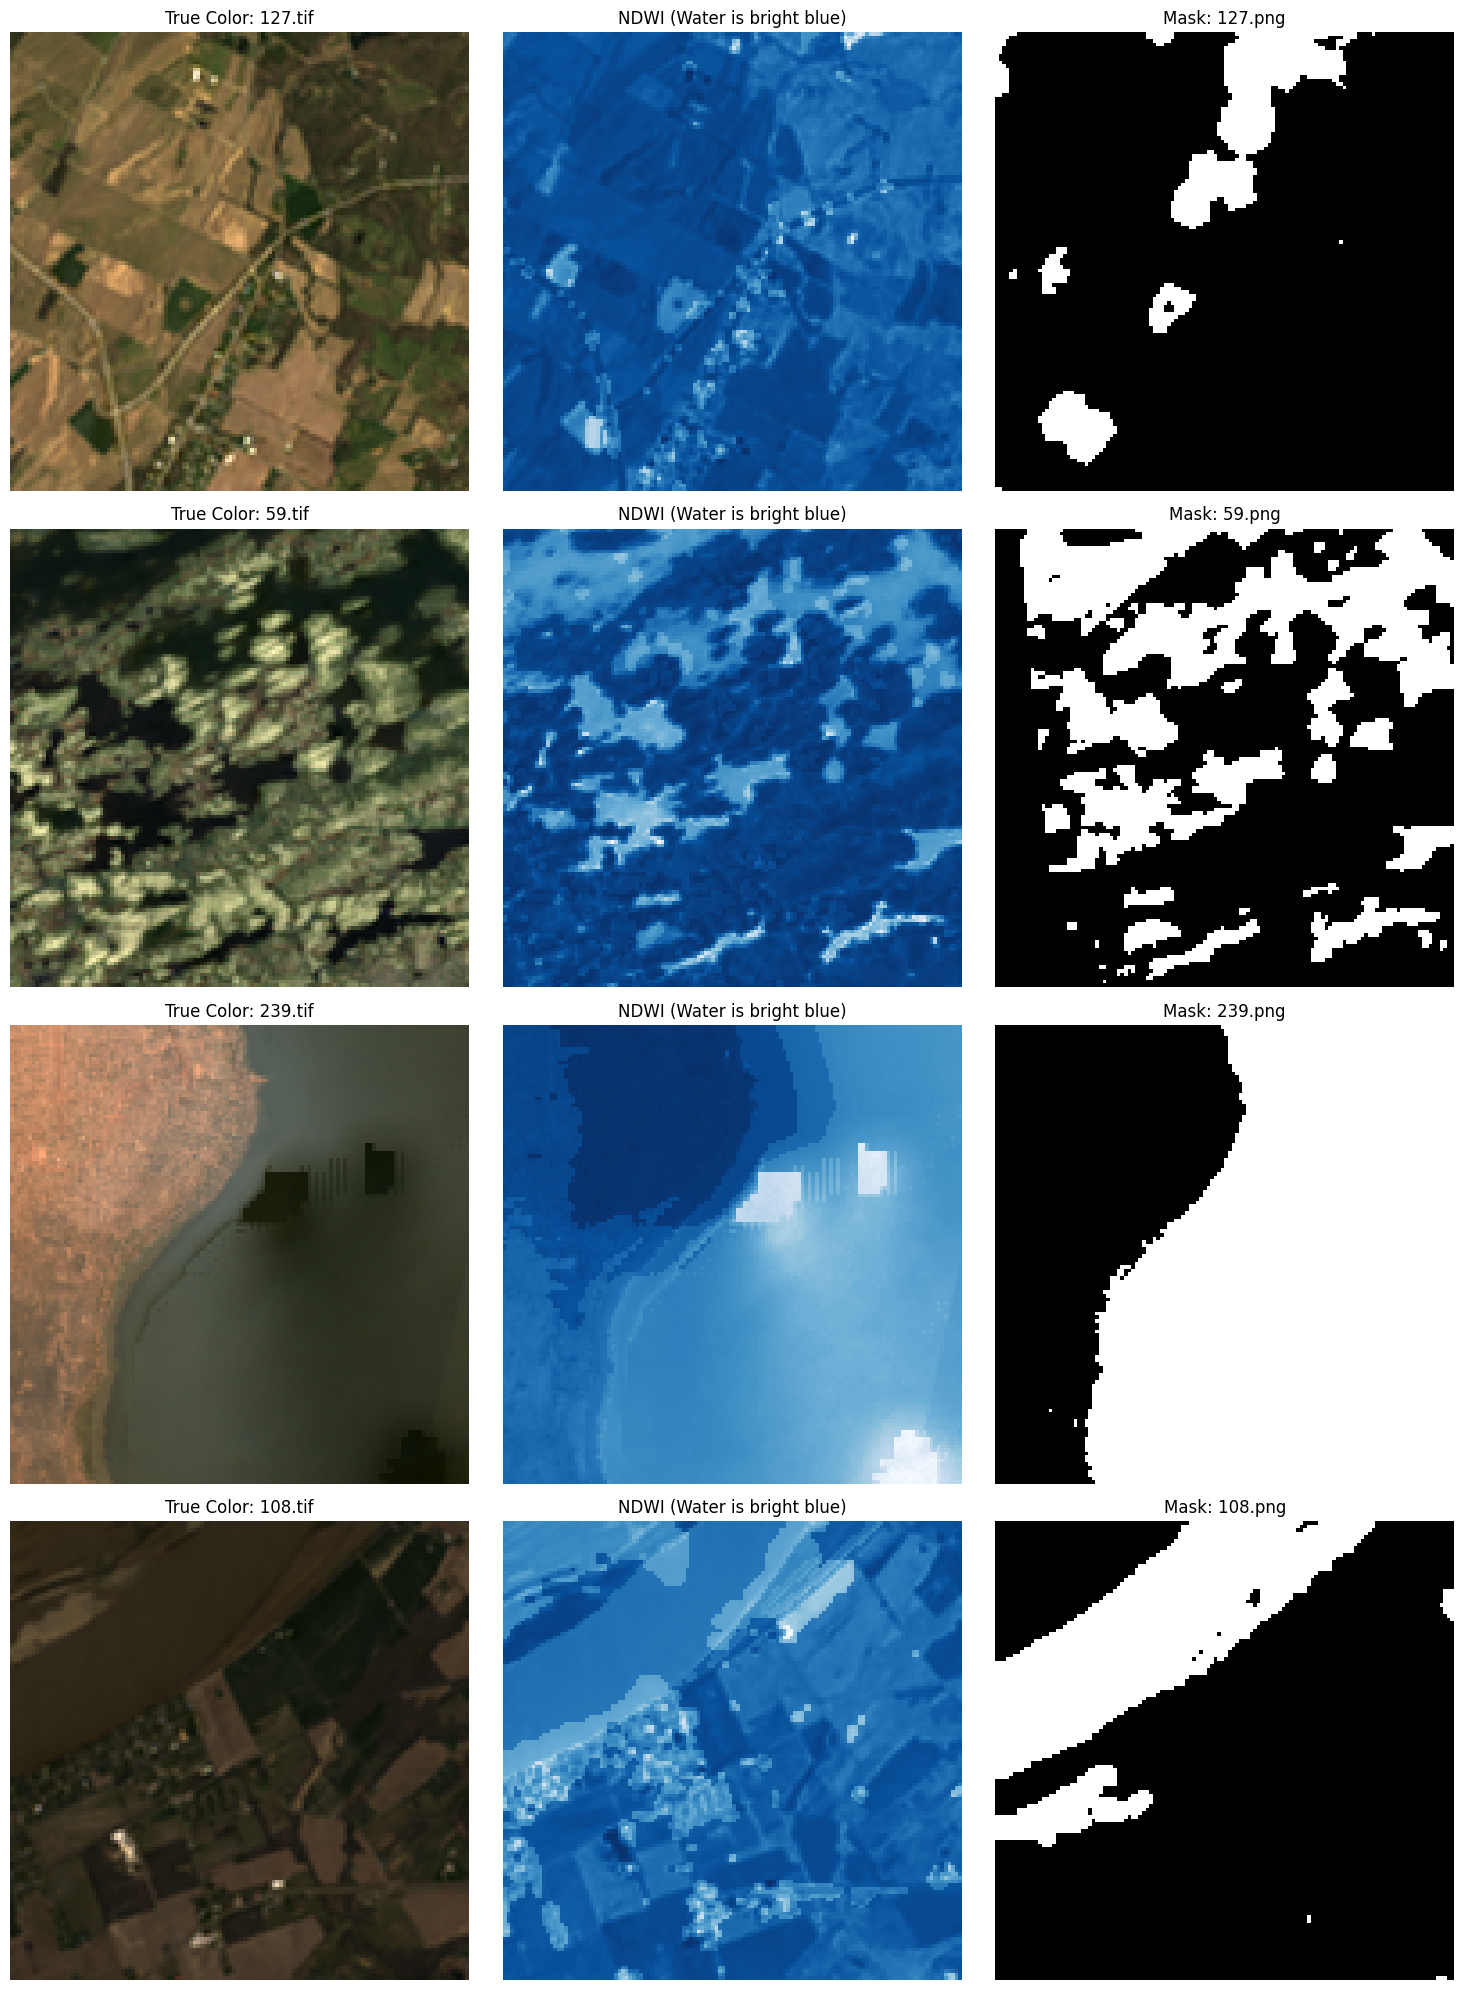

In [ ]:
# True Color vs. NDWI vs. Mask

if 'image_filenames' not in locals() or not image_filenames:
    image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.tif')]

if image_filenames:
    # Select a few random files to display
    num_samples_to_show = 4
    if len(image_filenames) < num_samples_to_show:
        num_samples_to_show = len(image_filenames)

    sample_image_files = random.sample(image_filenames, num_samples_to_show)

    # Let's create a plot with 3 columns now
    fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(15, 5 * num_samples_to_show))
    if num_samples_to_show == 1:
        axes = np.array([axes])

    print("Displaying True Color vs. NDWI vs. Ground Truth Mask...")

    for i, img_filename in enumerate(sample_image_files):
        base_name = os.path.splitext(img_filename)[0]
        mask_filename = f"{base_name}.png"

        img_path = os.path.join(image_dir, img_filename)
        mask_path = os.path.join(mask_dir, mask_filename)

        image_np = tiff.imread(img_path)
        mask_np = np.array(Image.open(mask_path))

        # Re-order if channels are first: (12, H, W) -> (H, W, 12)
        if image_np.shape[0] == 12:
            image_np = np.transpose(image_np, (1, 2, 0))

        # Column 1: True Color Image
        true_color_img = image_np[:, :, [3, 2, 1]] # Bands 4, 3, 2
        # Normalize for display
        min_val, max_val = true_color_img.min(), true_color_img.max()
        if max_val > min_val:
            true_color_img = (true_color_img - min_val) / (max_val - min_val)

        ax_true_color = axes[i, 0]
        ax_true_color.imshow(true_color_img)
        ax_true_color.set_title(f"True Color: {img_filename}")
        ax_true_color.axis('off')

        # Column 2: NDWI Calculation and Visualization
        # Green is Band 3 (index 2), NIR is Band 8 (index 7)
        green_band = image_np[:, :, 2].astype(np.float32)
        nir_band = image_np[:, :, 7].astype(np.float32)

        # Calculate NDWI. Add a small epsilon to avoid division by zero.
        numerator = green_band - nir_band
        denominator = green_band + nir_band + 1e-10
        ndwi = numerator / denominator

        ax_ndwi = axes[i, 1]
        im = ax_ndwi.imshow(ndwi, cmap='Blues') # Use a blue colormap to highlight water
        ax_ndwi.set_title("NDWI (Water is bright blue)")
        ax_ndwi.axis('off')

        # Column 3: Ground Truth Mask
        ax_mask = axes[i, 2]
        ax_mask.imshow(mask_np, cmap='gray')
        ax_mask.set_title(f"Mask: {mask_filename}")
        ax_mask.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("No image files found.")

# **UNet**

In [11]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

# ---------------------------------------------------------------------------------------------------------------- #

def encoder_block(inputs, num_filters):
    """Encoder block: conv_block -> max_pool."""
    # Returns both the pre-pooled features (f) for the skip connection
    # and the pooled features (p) for the next block.
    f = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(f)
    return f, p

# ---------------------------------------------------------------------------------------------------------------- #

def decoder_block(inputs, skip_features, num_filters):
    """Decoder block: upsample -> concatenate -> conv_block."""
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# ---------------------------------------------------------------------------------------------------------------- #

def build_unet(input_shape):
    """Build the complete U-Net model."""
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder Path

    f1, p1 = encoder_block(inputs, 64)
    f2, p2 = encoder_block(p1, 128)
    f3, p3 = encoder_block(p2, 256)
    f4, p4 = encoder_block(p3, 512)

    # Bottleneck
    bottleneck = conv_block(p4, 1024)

    # Decoder Path

    d1 = decoder_block(bottleneck, f4, 512)
    d2 = decoder_block(d1, f3, 256)
    d3 = decoder_block(d2, f2, 128)
    d4 = decoder_block(d3, f1, 64)

    # Output Layer
    outputs = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model

# ---------------------------------------------------------------------------------------------------------------- #

if __name__ == '__main__':
    model = build_unet(input_shape=(128, 128, 12))
    model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,060,481 (118.49 MB)

 Trainable params: 31,048,705 (118.44 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [12]:
# DATA PREPARATION FOR TRAINING

# Get the final, cleaned list of all image paths
all_image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.tif')])

# Split the data into training and validation sets (80% train, 20% validation)
train_paths, val_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)

print(f"Total images: {len(all_image_paths)}")
print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 12
BATCH_SIZE = 16

Total images: 306
Training images: 244
Validation images: 62


In [13]:
def parse_data(image_path_tensor):
    # Convert the tensor path to a regular python string
    image_path = image_path_tensor.numpy().decode('utf-8')

    # Process Image
    # Use tifffile to read the 12-channel image
    image = tiff.imread(image_path)
    # The image might be (12, 128, 128), we need (128, 128, 12)
    if image.shape[0] == IMG_CHANNELS:
        image = np.transpose(image, (1, 2, 0))
    image = image.astype(np.float32)

    # Process Mask
    # Derive mask path and use Pillow
    mask_path = image_path.replace("/images/", "/labels/").replace(".tif", ".png")
    mask = np.array(Image.open(mask_path))
    # Add a channel dimension to the mask (128, 128) -> (128, 128, 1)
    mask = np.expand_dims(mask, axis=-1)
    mask = mask.astype(np.float32)

    return image, mask

def load_and_preprocess(image_path):
    """ Wraps the pure python 'parse_data' function for use in a tf.data pipeline """
    # Use tf.py_function to wrap the parsing logic
    # We must specify the output types (tf.float32 for both image and mask)
    image, mask = tf.py_function(parse_data, [image_path], [tf.float32, tf.float32])

    # We must explicitly set the shapes after using tf.py_function
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])

    return image, mask

def create_dataset(paths, batch_size):
    """Creates a tf.data.Dataset pipeline."""
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(paths))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create the datasets
train_dataset = create_dataset(train_paths, BATCH_SIZE)
val_dataset = create_dataset(val_paths, BATCH_SIZE)
print("\n✅ tf.data pipelines created successfully using tf.py_function.")


✅ tf.data pipelines created successfully using tf.py_function.


In [ ]:
# Build the model
model = build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Define metrics
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.BinaryIoU(name='iou', target_class_ids=[1])
]

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=metrics
)

# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_water_segmentation_model.keras', save_best_only=True, monitor='val_iou', mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_iou', mode='max', patience=5, restore_best_weights=True)
]

In [ ]:
print("\n--- Starting Model Training ---")
model.summary()

EPOCHS = 25
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks
)
print("\n--- ✅ Training Complete ---")


--- Starting Model Training ---


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_36[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ activation_37[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_38[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ activation_39[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_42[0][0] 

 Total params: 31,060,481 (118.49 MB)

 Trainable params: 31,048,705 (118.44 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.4775 - iou: 0.3279 - loss: 0.8043 - precision: 0.3365 - recall: 0.9304 - val_accuracy: 0.8553 - val_iou: 0.5135 - val_loss: 0.5101 - val_precision: 0.6765 - val_recall: 0.6806
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 297ms/step - accuracy: 0.8445 - iou: 0.5532 - loss: 0.4644 - precision: 0.6598 - recall: 0.7767 - val_accuracy: 0.6647 - val_iou: 0.3624 - val_loss: 0.5834 - val_precision: 0.3873 - val_recall: 0.8495
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 472ms/step - accuracy: 0.8818 - iou: 0.6263 - loss: 0.3834 - precision: 0.8057 - recall: 0.7376 - val_accuracy: 0.8678 - val_iou: 0.5536 - val_loss: 0.4855 - val_precision: 0.6952 - val_recall: 0.7310
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 716ms/step - accuracy: 0.9130 - iou: 0.6880 - loss: 0.3006 - precision: 0.8959 - recall: 0.7476 - val_accuracy: 0.8981 - val_iou: 0.6106 - val_loss: 0.4240 - val_precision: 0.8109 - val_recall: 0.7120
Epoch 5/25
16/16 ━━━━━━━━━━━━━━

In [14]:
def plot_training_history(history):
    """Plots training and validation metrics over epochs."""

    history_dict = history.history
    epochs = history.epoch

    # Get metrics
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    precision = history_dict.get('precision', [0] * len(epochs))
    val_precision = history_dict.get('val_precision', [0] * len(epochs))
    recall = history_dict.get('recall', [0] * len(epochs))
    val_recall = history_dict.get('val_recall', [0] * len(epochs))
    iou = history_dict.get('iou', [0] * len(epochs))
    val_iou = history_dict.get('val_iou', [0] * len(epochs))

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot Precision and Recall
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, precision, 'b', label='Training Precision')
    plt.plot(epochs, val_precision, 'y', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, recall, 'b', label='Training Recall')
    plt.plot(epochs, val_recall, 'y', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()

    # Plot IoU
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, iou, 'purple', label='Training IoU')
    plt.plot(epochs, val_iou, 'orange', label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.show()

In [ ]:
# Call the new plotting function
plot_training_history(history)



In [ ]:
# Specify the path to save the model in Google Drive
model_save_path = '/content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_UNET.keras'

# Save the model
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_UNET.keras


# **FINAL EVALUATION: VISUALIZE SPECIFIC PREDICTIONS VS. GROUND TRUTH**

Loading model from: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Model/Water_Segmentation_Model_UNET.keras
✅ Model loaded successfully.

Looking for specified images...
  ✅ Found: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data/images/104.tif
  ✅ Found: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data/images/120.tif
  ✅ Found: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data/images/298.tif


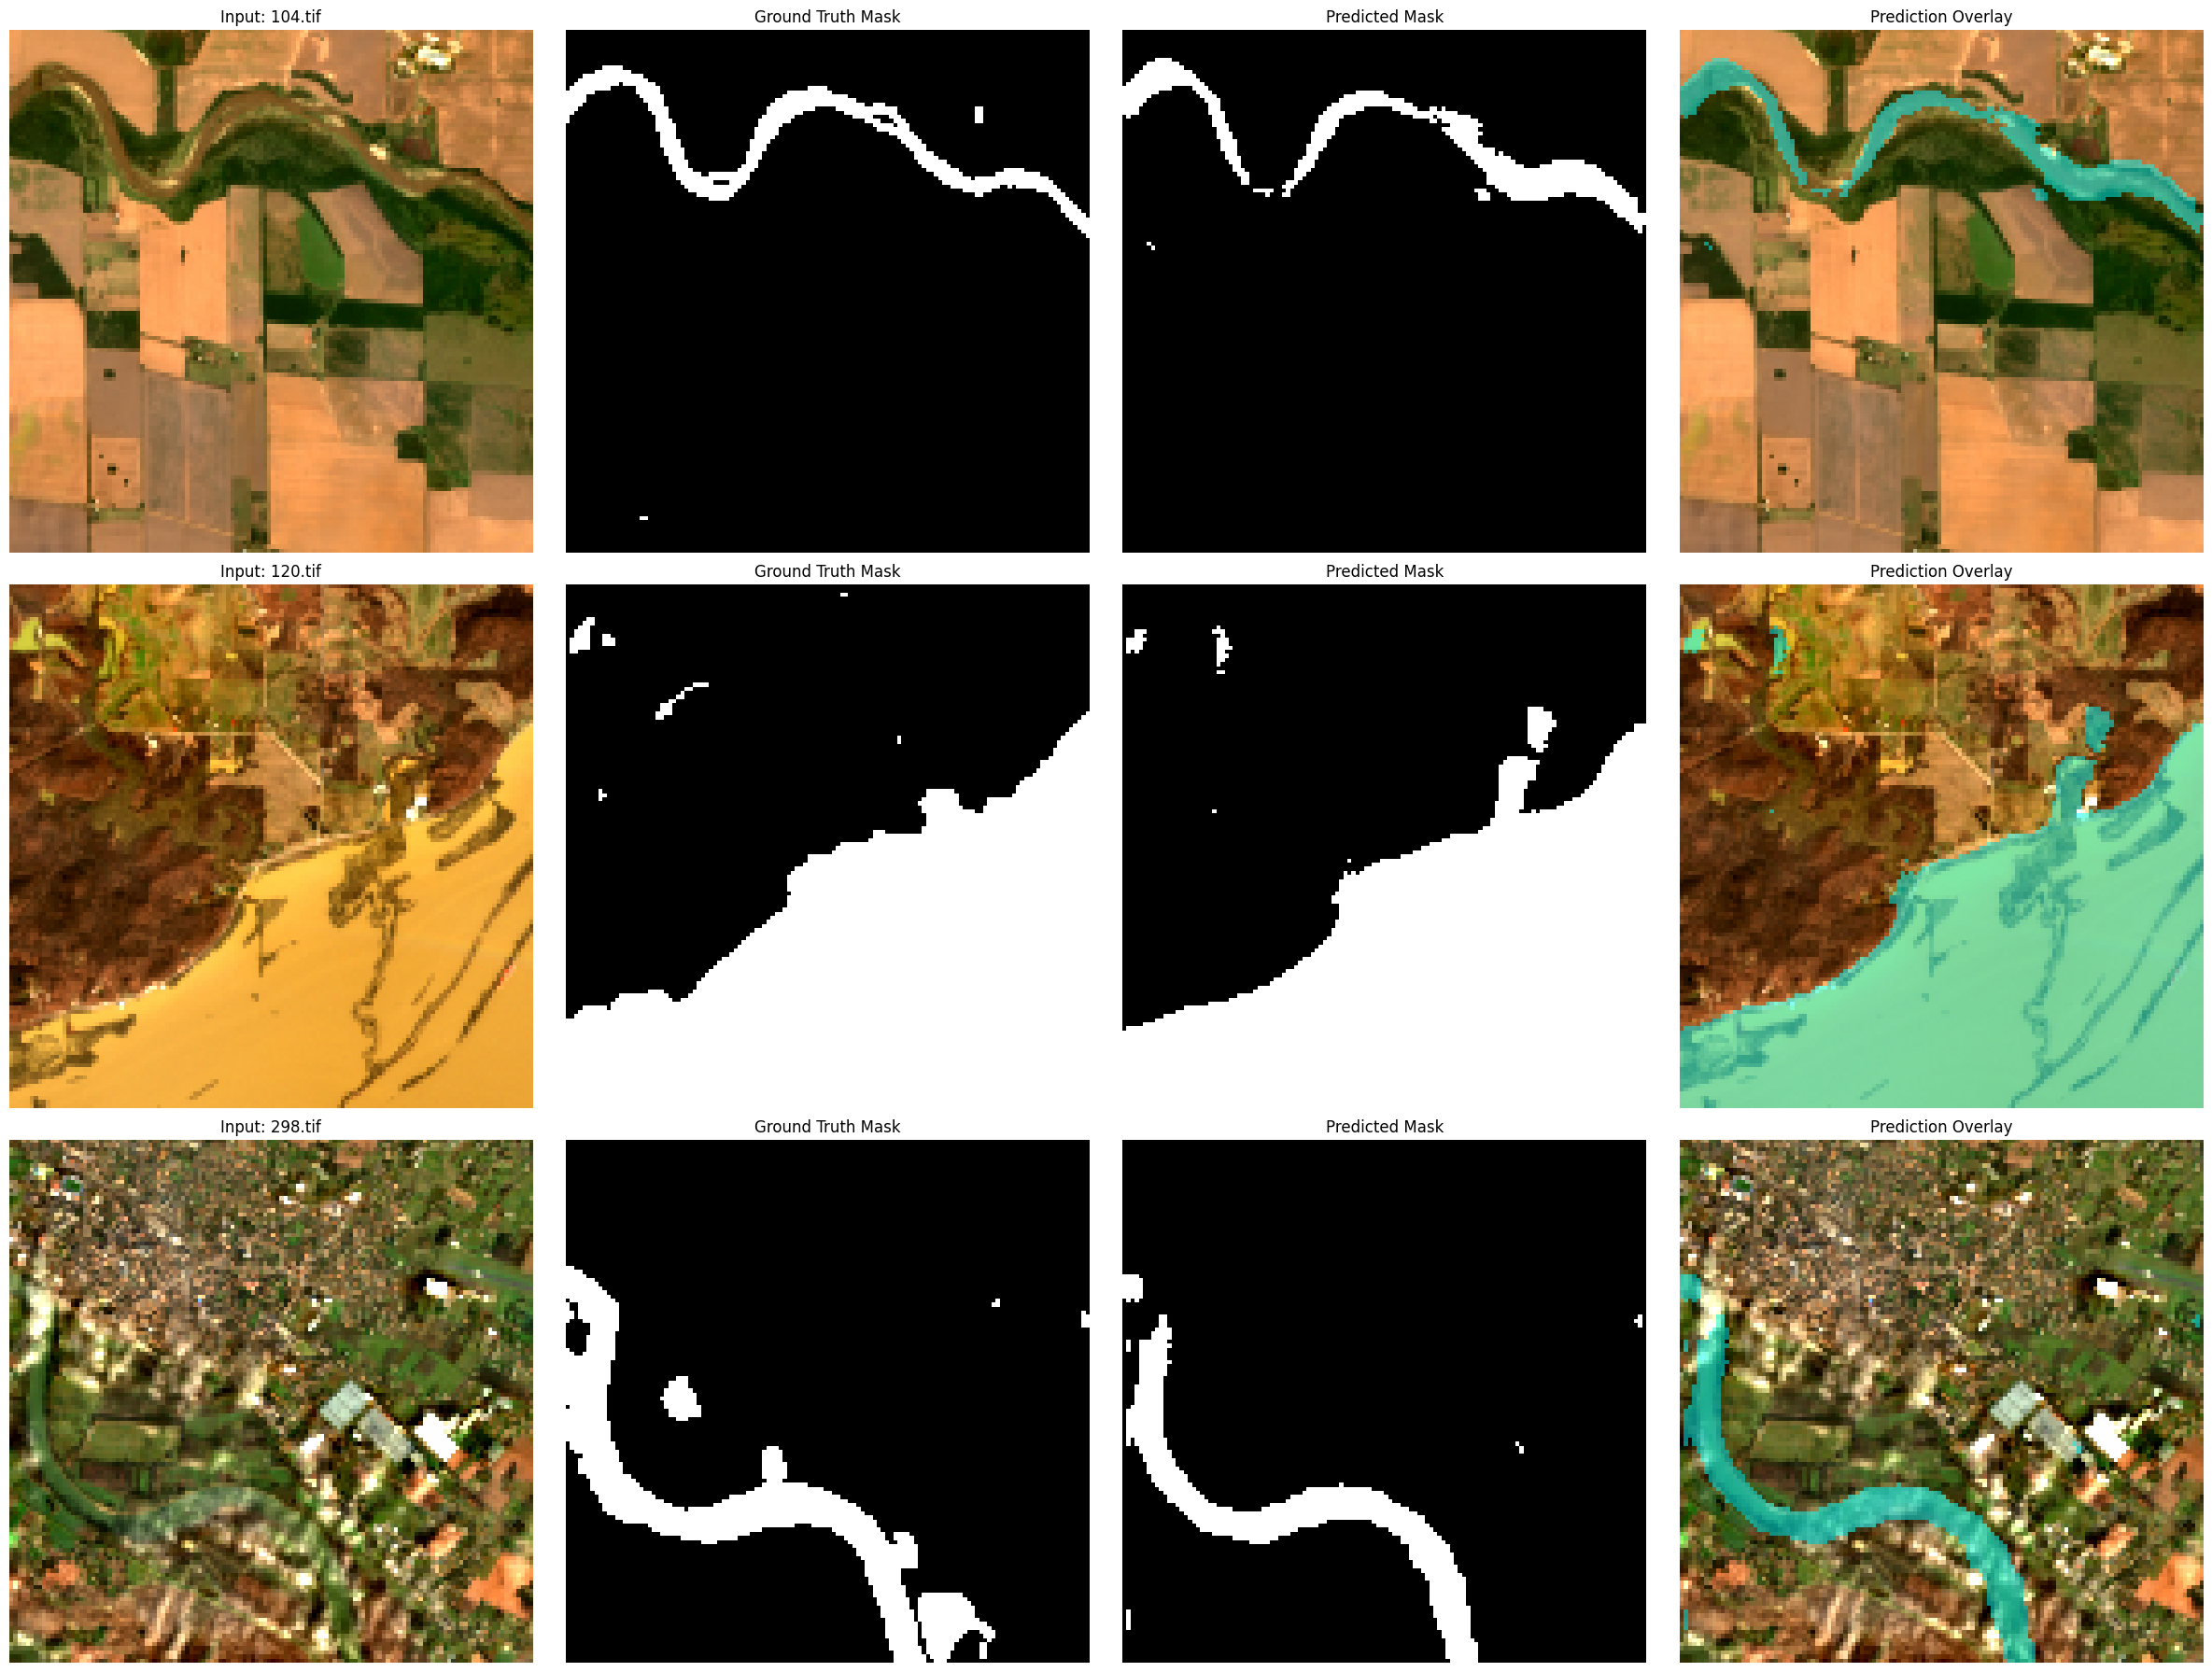

In [ ]:
# Load the best-saved model
model_path = '/content/drive/MyDrive/Cellula Technology/Water Segmentation/Model/Water_Segmentation_Model_UNET.keras'
try:
    print(f"Loading model from: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# ---------------------------------------------------------------------------------------------------------------- #

target_basenames = ['104', '120', '298']
test_image_paths = []

print("\nLooking for specified images...")
for basename in target_basenames:
    # Construct the full path to the image
    path = os.path.join(image_dir, f"{basename}.tif")

    # Check if the file actually exists before adding it to our list
    if os.path.exists(path):
        print(f"  ✅ Found: {path}")
        test_image_paths.append(path)
    else:
        print(f"  ⚠️ Warning: Could not find image at {path}. It will be skipped.")

if not test_image_paths:
    print("\n❌ None of the specified images were found. Aborting visualization.")
    # You can stop here if no images were found
    raise FileNotFoundError("Could not find any of the specified images to test.")

num_samples_to_show = len(test_image_paths)

# ---------------------------------------------------------------------------------------------------------------- #

# Create a 4-column subplot for the results
fig, axes = plt.subplots(num_samples_to_show, 4, figsize=(24, 6 * num_samples_to_show))
if num_samples_to_show == 1:
    axes = np.array([axes])

# Loop through each specified test image, predict, and plot

for i, test_image_path in enumerate(test_image_paths):

    # A. Load and preprocess the input image
    input_image = tiff.imread(test_image_path)
    if input_image.shape[0] == IMG_CHANNELS:
        input_image = np.transpose(input_image, (1, 2, 0))

    input_image_for_model = np.expand_dims(input_image.astype(np.float32), axis=0)

    # B. Load the corresponding Ground Truth mask
    ground_truth_path = test_image_path.replace("/images/", "/labels/").replace(".tif", ".png")
    ground_truth_mask = np.array(Image.open(ground_truth_path))

    # C. Make a prediction with the model
    predicted_mask_prob = model.predict(input_image_for_model, verbose=0)

    # D. Post-process the prediction
    threshold = 0.5
    predicted_mask = (predicted_mask_prob[0] > threshold).astype(np.uint8)

    # E. Prepare the True Color image for display
    def normalize_for_display(band_data):
        p2, p98 = np.percentile(band_data, (2, 98))
        clipped_data = np.clip(band_data, p2, p98)
        return (clipped_data - p2) / (p98 - p2 + 1e-8)

    true_color_display = input_image[:, :, [3, 2, 1]].copy()
    true_color_display = normalize_for_display(true_color_display)

    # F. Plot all four results for this sample

    # Column 1: Input Image
    axes[i, 0].imshow(true_color_display)
    axes[i, 0].set_title(f'Input: {os.path.basename(test_image_path)}')
    axes[i, 0].axis('off')

    # Column 2: Ground Truth Mask
    axes[i, 1].imshow(ground_truth_mask, cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask')
    axes[i, 1].axis('off')

    # Column 3: Predicted Mask
    axes[i, 2].imshow(predicted_mask, cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

    # Column 4: Prediction Overlay
    cmap_overlay = ListedColormap(['none', 'cyan'])
    axes[i, 3].imshow(true_color_display)
    axes[i, 3].imshow(predicted_mask, cmap=cmap_overlay, alpha=0.5)
    axes[i, 3].set_title('Prediction Overlay')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

# **Native ResNet50**

In [14]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# The Main Model Building Function
def build_resnet50_unet(input_shape):
    """ Builds a U-Net model using a pre-trained ResNet50 from tf.keras.applications as the encoder. """
    # Define the 12-channel input layer for our final model
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Create the input adapter layer to compress 12 channels to 3
    entry_conv = tf.keras.layers.Conv2D(3, (1, 1), padding='same', name='input_adapter')(inputs)

    # Instantiate the ResNet50 backbone in the standard way
    # This ensures its architecture matches the pre-trained weights exactly.
    backbone = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Freeze the backbone layers for initial training
    backbone.trainable = False

    # Create a new model that defines the encoder path
    # This model will take the backbone's standard input and output the layers we need for skip connections.
    skip_names = [
        'conv1_relu',         # 64x64
        'conv2_block3_out',   # 32x32
        'conv3_block4_out',   # 16x16
        'conv4_block6_out',   # 8x8
    ]
    # Get the actual layer output tensors from the backbone
    encoder_outputs = [backbone.get_layer(name).output for name in skip_names]

    # Create the encoder model
    encoder = tf.keras.models.Model(
        inputs=backbone.input,
        outputs=encoder_outputs,
        name='resnet50_encoder'
    )

    # Pass our 12-to-3 channel adapted input through the encoder model
    all_skips_and_bottleneck = encoder(entry_conv)

    # Unpack the list of outputs from the encoder
    skip_connections = all_skips_and_bottleneck[:-1]
    bottleneck = all_skips_and_bottleneck[-1]

    # Build the Decoder Path
    # The decoder upsamples from the bottleneck, concatenating with the skip connections.
    # We must reverse the skip_connections list to match the decoder's bottom-up path.
    d1 = decoder_block(bottleneck, skip_connections[::-1][0], 256) # 16x16
    d2 = decoder_block(d1, skip_connections[::-1][1], 128)         # 32x32
    d3 = decoder_block(d2, skip_connections[::-1][2], 64)          # 64x64

    # Final upsample to match the original 128x128 resolution
    d4 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=2, padding='same')(d3)
    d4 = conv_block(d4, 32)

    # Final Output Layer
    outputs = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid', name='final_output')(d4)

    # Create and return the final U-Net model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='ResNet50_U-Net')
    return model

In [ ]:
# Define input shape
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Build the model
native_pretrained_model = build_resnet50_unet(INPUT_SHAPE)

# Compile the model
native_pretrained_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryIoU(name='iou', target_class_ids=[1])
    ]
)

# Define callbacks
native_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_native_resnet50_model.keras',
        save_best_only=True, monitor='val_iou', mode='max'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_iou', mode='max', patience=6, restore_best_weights=True
    )
]

print("\n Starting TensorFlow-Native Pre-trained Model Training (ResNet50-UNet)")
native_pretrained_model.summary()


--- Starting TensorFlow-Native Pre-trained Model Training (ResNet50-UNet) ---
Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 12)]       0         []                            
                                                                                                  
 input_adapter (Conv2D)      (None, 128, 128, 3)          39        ['input_3[0][0]']             
                                                                                                  
 resnet50_encoder (Function  [(None, 64, 64, 64),         8589184   ['input_adapter[0][0]']       
 al)                          (None, 32, 32, 256),                                                
                              (None, 16, 16, 512),                                                
      

In [ ]:
EPOCHS = 30
native_history = native_pretrained_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=native_callbacks
)
print("\n--- ✅ TensorFlow-Native Pre-trained Model Training Complete ---")

Epoch 1/30
16/16 [==============================] - 288s 9s/step - loss: 0.6560 - accuracy: 0.6265 - precision: 0.3834 - recall: 0.6403 - iou: 0.3154 - val_loss: 0.6982 - val_accuracy: 0.5430 - val_precision: 0.2986 - val_recall: 0.7687 - val_iou: 0.2740
Epoch 2/30
16/16 [==============================] - 116s 7s/step - loss: 0.5142 - accuracy: 0.8042 - precision: 0.6201 - recall: 0.7005 - iou: 0.4902 - val_loss: 0.6796 - val_accuracy: 0.5713 - val_precision: 0.3195 - val_recall: 0.8059 - val_iou: 0.2966
Epoch 3/30
16/16 [==============================] - 117s 7s/step - loss: 0.4555 - accuracy: 0.8355 - precision: 0.6908 - recall: 0.7021 - iou: 0.5342 - val_loss: 0.6078 - val_accuracy: 0.8395 - val_precision: 0.6319 - val_recall: 0.6818 - val_iou: 0.4879
Epoch 4/30
16/16 [==============================] - 119s 7s/step - loss: 0.4102 - accuracy: 0.8602 - precision: 0.7730 - recall: 0.6792 - iou: 0.5662 - val_loss: 0.5618 - val_accuracy: 0.8892 - val_precision: 0.8188 - val_recall: 0.650

In [ ]:
native_model_save_path = '/content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_Native_ResNet50_UNET.keras'
native_pretrained_model.save(native_model_save_path)
print(f"Native pre-trained model saved to: {native_model_save_path}")

Native pre-trained model saved to: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_Native_ResNet50_UNET.keras


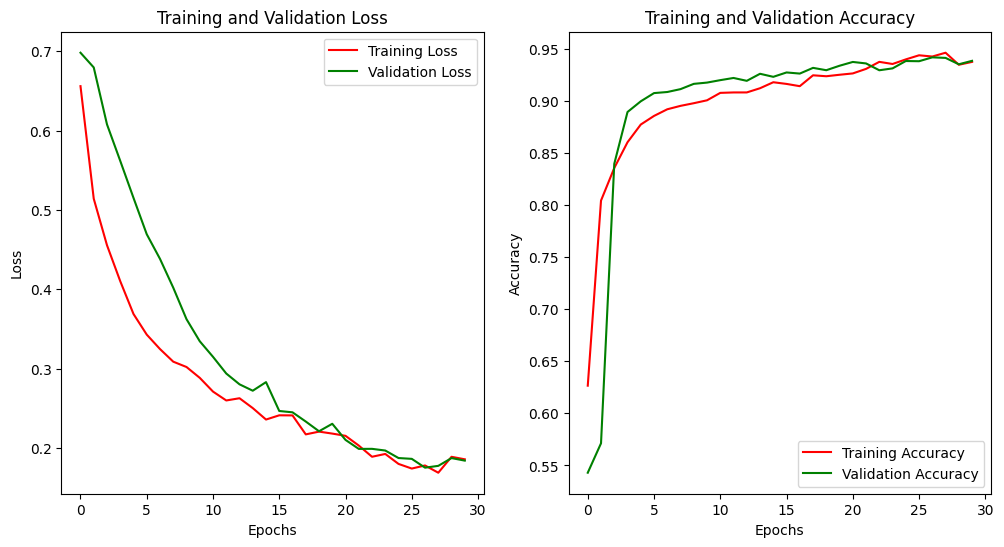

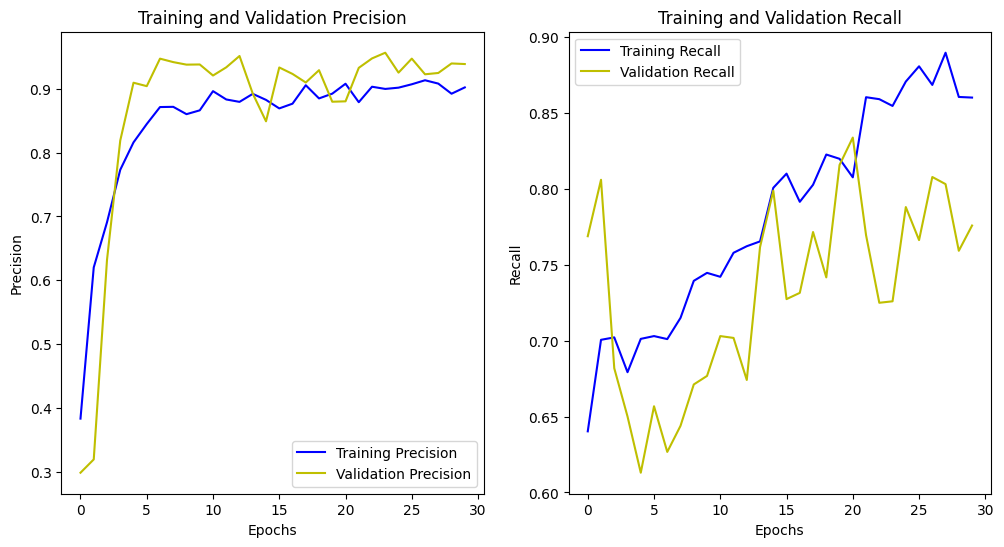

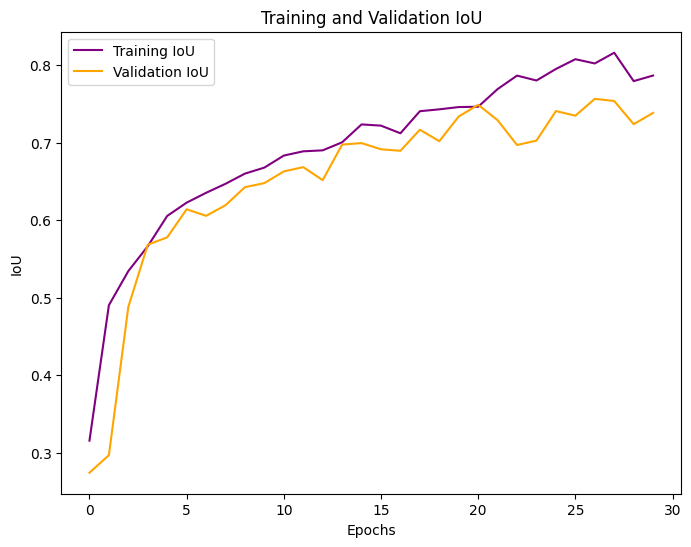

In [ ]:
plot_training_history(native_history)

Loading model from: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_Native_ResNet50_UNET.keras
✅ Model loaded successfully.

Looking for specified images...
  ✅ Found: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data/images/104.tif
  ✅ Found: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data/images/120.tif
  ✅ Found: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data/images/298.tif


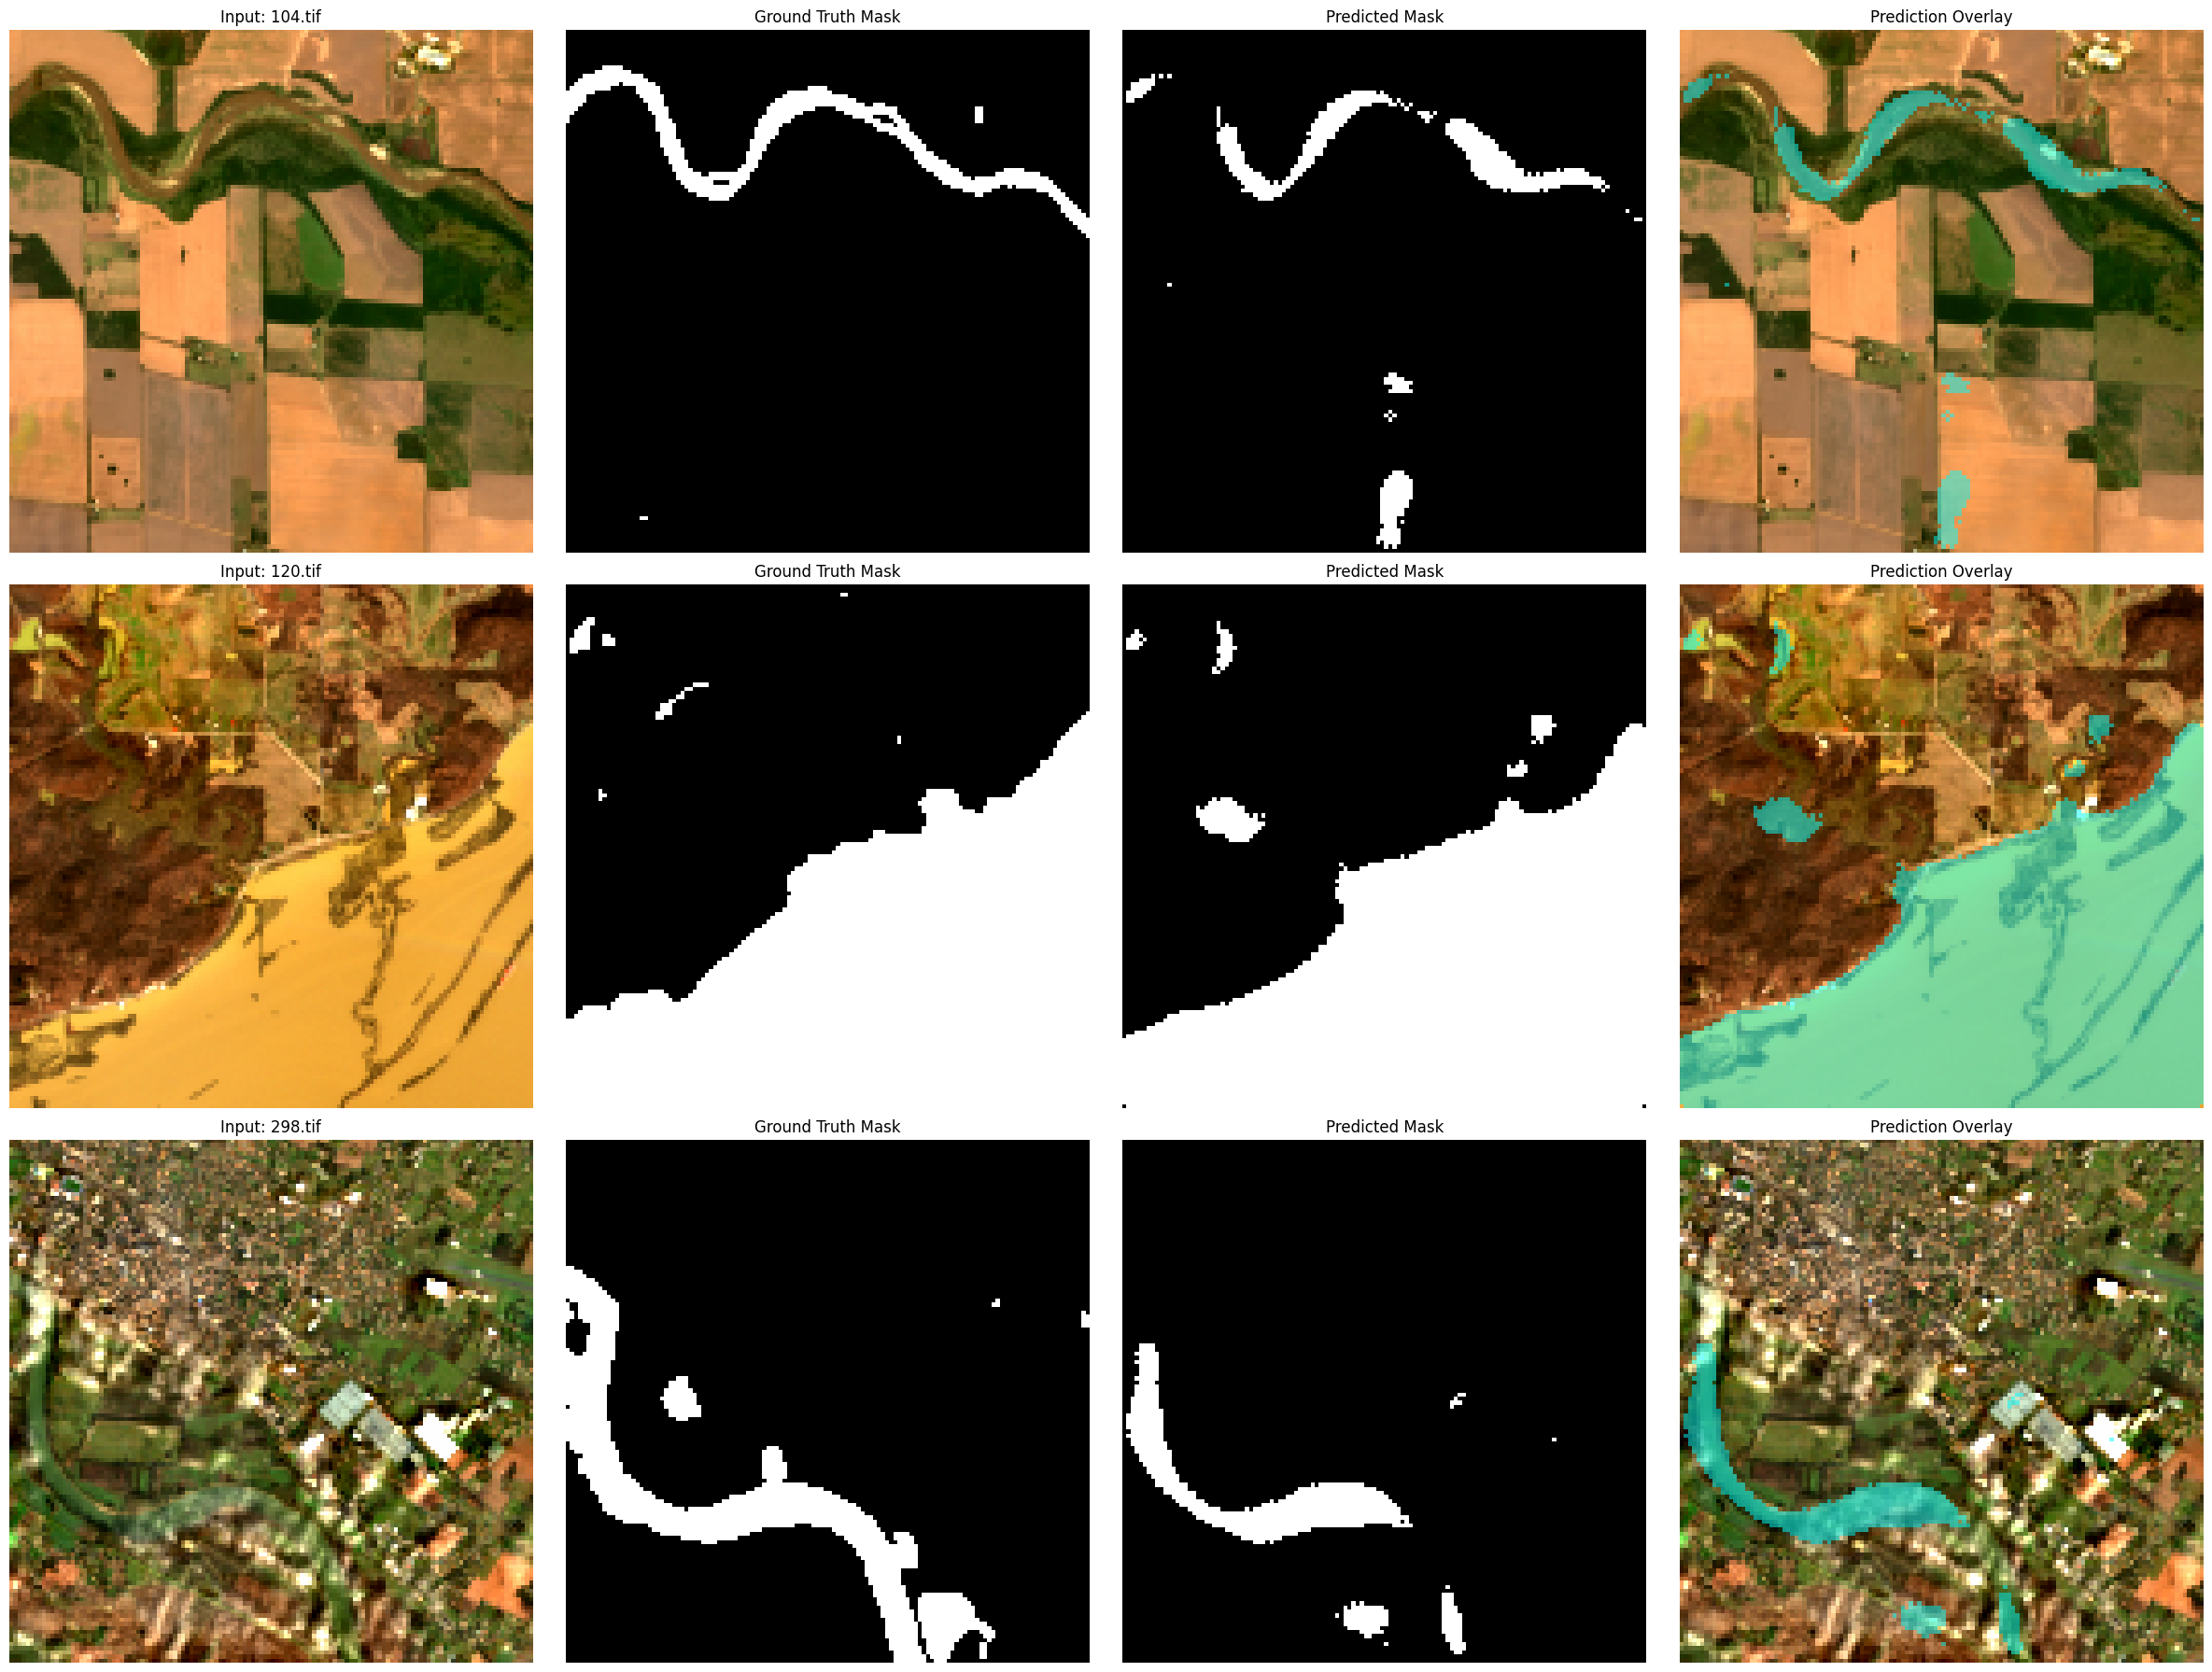

In [ ]:
# Load the best-saved model
model_path = '/content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_Native_ResNet50_UNET.keras'
try:
    print(f"Loading model from: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# ---------------------------------------------------------------------------------------------------------------- #

target_basenames = ['104', '120', '298']
test_image_paths = []

print("\nLooking for specified images...")
for basename in target_basenames:
    # Construct the full path to the image
    path = os.path.join(image_dir, f"{basename}.tif")

    # Check if the file actually exists before adding it to our list
    if os.path.exists(path):
        print(f"  ✅ Found: {path}")
        test_image_paths.append(path)
    else:
        print(f"  ⚠️ Warning: Could not find image at {path}. It will be skipped.")

if not test_image_paths:
    print("\n❌ None of the specified images were found. Aborting visualization.")
    # You can stop here if no images were found
    raise FileNotFoundError("Could not find any of the specified images to test.")

num_samples_to_show = len(test_image_paths)

# ---------------------------------------------------------------------------------------------------------------- #

# Create a 4-column subplot for the results
fig, axes = plt.subplots(num_samples_to_show, 4, figsize=(24, 6 * num_samples_to_show))
if num_samples_to_show == 1:
    axes = np.array([axes])

# Loop through each specified test image, predict, and plot

for i, test_image_path in enumerate(test_image_paths):

    # A. Load and preprocess the input image
    input_image = tiff.imread(test_image_path)
    if input_image.shape[0] == IMG_CHANNELS:
        input_image = np.transpose(input_image, (1, 2, 0))

    input_image_for_model = np.expand_dims(input_image.astype(np.float32), axis=0)

    # B. Load the corresponding Ground Truth mask
    ground_truth_path = test_image_path.replace("/images/", "/labels/").replace(".tif", ".png")
    ground_truth_mask = np.array(Image.open(ground_truth_path))

    # C. Make a prediction with the model
    predicted_mask_prob = model.predict(input_image_for_model, verbose=0)

    # D. Post-process the prediction
    threshold = 0.5
    predicted_mask = (predicted_mask_prob[0] > threshold).astype(np.uint8)

    # E. Prepare the True Color image for display
    def normalize_for_display(band_data):
        p2, p98 = np.percentile(band_data, (2, 98))
        clipped_data = np.clip(band_data, p2, p98)
        return (clipped_data - p2) / (p98 - p2 + 1e-8)

    true_color_display = input_image[:, :, [3, 2, 1]].copy()
    true_color_display = normalize_for_display(true_color_display)

    # F. Plot all four results for this sample

    # Column 1: Input Image
    axes[i, 0].imshow(true_color_display)
    axes[i, 0].set_title(f'Input: {os.path.basename(test_image_path)}')
    axes[i, 0].axis('off')

    # Column 2: Ground Truth Mask
    axes[i, 1].imshow(ground_truth_mask, cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask')
    axes[i, 1].axis('off')

    # Column 3: Predicted Mask
    axes[i, 2].imshow(predicted_mask, cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

    # Column 4: Prediction Overlay
    cmap_overlay = ListedColormap(['none', 'cyan'])
    axes[i, 3].imshow(true_color_display)
    axes[i, 3].imshow(predicted_mask, cmap=cmap_overlay, alpha=0.5)
    axes[i, 3].set_title('Prediction Overlay')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

# **FineTune ResNet50**

In [34]:
def build_resnet50_unet_v2(input_shape):
    """
    This architecture is designed for a two-stage training: feature-extraction then fine-tuning.
    """
    print("-Building model with complete ResNet50 encoder")

    # Define the 12-channel input layer
    inputs = tf.keras.layers.Input(shape=input_shape)
    entry_conv = tf.keras.layers.Conv2D(3, (1, 1), padding='same', name='input_adapter')(inputs)

    # Instantiate the ResNet50 backbone, ensuring it's complete
    backbone = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Define the layers to be used for skip connections and the bottleneck
    # We now include conv5_block3_out as the bottleneck
    skip_names = [
        'conv1_relu',
        'conv2_block3_out',
        'conv3_block4_out',
        'conv4_block6_out',
    ]
    bottleneck_name = 'conv5_block3_out'

    # Get the actual output tensors from the backbone layers
    skip_outputs = [backbone.get_layer(name).output for name in skip_names]
    bottleneck_output = backbone.get_layer(bottleneck_name).output

    # Create the functional encoder model from the backbone
    encoder = tf.keras.models.Model(
        inputs=backbone.input,
        outputs=skip_outputs + [bottleneck_output], # Output skips and bottleneck
        name='complete_resnet50_encoder'
    )

    # Build the Decoder Path
    # Connect our 12-channel data to the encoder
    all_encoder_outputs = encoder(entry_conv)
    skip_connections = all_encoder_outputs[:-1]
    bottleneck = all_encoder_outputs[-1]

    # The decoder upsamples from the bottleneck, concatenating with the skip connections.
    # The number of filters must match the skip connection channels.
    d1 = decoder_block(bottleneck, skip_connections[::-1][0], 512) # Skip from conv4 (1024 channels -> 512)
    d2 = decoder_block(d1, skip_connections[::-1][1], 256)         # Skip from conv3 (512 channels -> 256)
    d3 = decoder_block(d2, skip_connections[::-1][2], 128)         # Skip from conv2 (256 channels -> 128)
    d4 = decoder_block(d3, skip_connections[::-1][3], 64)          # Skip from conv1 (64 channels -> 64)

    # Final upsampling and output layer
    d5 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=2, padding='same')(d4)
    d5 = conv_block(d5, 32)
    outputs = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid', name='final_output')(d5)

    # Create the final U-Net model
    final_model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='Complete_ResNet50_U-Net')
    return final_model

In [35]:
print("STAGE 1: FEATURE EXTRACTION")

# Build the model
model = build_resnet50_unet_v2((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# FREEZE the encoder for the first stage
model.get_layer('complete_resnet50_encoder').trainable = False

# Compile with a standard learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(name='iou', target_class_ids=[1])]
)

print("\nModel summary with frozen encoder:")
model.summary()



--- STAGE 1: FEATURE EXTRACTION ---
--- Building model with complete ResNet50 encoder ---

Model summary with frozen encoder:


Model: "Complete_ResNet50_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_adapter       │ (None, 128, 128,  │         39 │ input_layer_5[0]… │
│ (Conv2D)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ complete_resnet50_… │ [(None, 64, 64,   │ 23,587,712 │ input_adapter[0]… │
│ (Functional)        │ 64), (None, 32,   │            │                   │
│                     │ 32, 256), (None,  │            │                   │
│                     │ 16, 16, 512),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 1024), (None, 4,  │            │                   │
│                     │ 4, 2048)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_14 │ (None, 8, 8, 512) │  4,194,816 │ complete_resnet5… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 8, 8,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1536)             │            │ complete_resnet5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 8, 8, 512) │  7,078,400 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ activation_38[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_15 │ (None, 16, 16,    │    524,544 │ activation_39[0]… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 768)              │            │ complete_resnet5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 16, 16,    │  1,769,728 │ concatenate_13[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 41,004,648 (156.42 MB)

 Trainable params: 17,412,968 (66.43 MB)

 Non-trainable params: 23,591,680 (90.00 MB)

In [36]:
initial_epochs = 30
print(f"\nTraining for {initial_epochs} epochs with the encoder frozen...")
history_initial = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset
)


Training for 30 epochs with the encoder frozen...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7724 - iou: 0.2010 - loss: 0.5384 - val_accuracy: 0.7752 - val_iou: 0.2832 - val_loss: 0.5343
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.8170 - iou: 0.4241 - loss: 0.4390 - val_accuracy: 0.8126 - val_iou: 0.4130 - val_loss: 0.5445
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.8533 - iou: 0.4976 - loss: 0.3721 - val_accuracy: 0.8703 - val_iou: 0.5094 - val_loss: 0.5105
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.8649 - iou: 0.5672 - loss: 0.3478 - val_accuracy: 0.8895 - val_iou: 0.5219 - val_loss: 0.4672
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.8805 - iou: 0.5921 - loss: 0.3247 - val_accuracy: 0.8933 - val_iou: 0.5308 - val_loss: 0.4357
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.8939 - iou: 0.6097 - loss: 0.2980 - val_accuracy: 0.9056 - val_iou: 0.5888 - val_loss

In [37]:
print("STAGE 2: FINE-TUNING")

# Get the encoder from our existing model object
encoder = model.get_layer('complete_resnet50_encoder')

# UNFREEZE the encoder
encoder.trainable = True

# Selectively re-freeze the earliest layers
fine_tune_start_prefix = 'conv5_block1'
fine_tune_at_index = -1
for i, layer in enumerate(encoder.layers):
    if layer.name.startswith(fine_tune_start_prefix):
        fine_tune_at_index = i
        break

if fine_tune_at_index != -1:
    print(f"\nFreezing encoder layers up to index {fine_tune_at_index} ('{fine_tune_start_prefix}').")
    for layer in encoder.layers[:fine_tune_at_index]:
        layer.trainable = False

# Re-compile with a very low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Crucial low learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.BinaryIoU(name='iou', target_class_ids=[1])]
)

print("\nModel summary for fine-tuning:")
model.summary()


--- STAGE 2: FINE-TUNING ---

Freezing encoder layers up to index 143 ('conv5_block1').

Model summary for fine-tuning:


Model: "Complete_ResNet50_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_adapter       │ (None, 128, 128,  │         39 │ input_layer_5[0]… │
│ (Conv2D)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ complete_resnet50_… │ [(None, 64, 64,   │ 23,587,712 │ input_adapter[0]… │
│ (Functional)        │ 64), (None, 32,   │            │                   │
│                     │ 32, 256), (None,  │            │                   │
│                     │ 16, 16, 512),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 1024), (None, 4,  │            │                   │
│                     │ 4, 2048)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_14 │ (None, 8, 8, 512) │  4,194,816 │ complete_resnet5… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 8, 8,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1536)             │            │ complete_resnet5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 8, 8, 512) │  7,078,400 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ activation_38[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_15 │ (None, 16, 16,    │    524,544 │ activation_39[0]… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 768)              │            │ complete_resnet5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 16, 16,    │  1,769,728 │ concatenate_13[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 41,004,648 (156.42 MB)

 Trainable params: 32,388,968 (123.55 MB)

 Non-trainable params: 8,615,680 (32.87 MB)

In [38]:
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

# Define callbacks for saving the best fine-tuned model
finetune_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_finetuned_model.keras',
        save_best_only=True, monitor='val_iou', mode='max'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_iou', mode='max', patience=5, restore_best_weights=True
    )
]

In [39]:
print(f"\nFine-tuning for up to {fine_tune_epochs} more epochs...")
history_finetune = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1] + 1,
    validation_data=val_dataset,
    callbacks=finetune_callbacks
)


Fine-tuning for up to 30 more epochs...
Epoch 31/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9380 - iou: 0.7841 - loss: 0.1610 - val_accuracy: 0.9338 - val_iou: 0.7125 - val_loss: 0.1739
Epoch 32/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9434 - iou: 0.8148 - loss: 0.1483 - val_accuracy: 0.9431 - val_iou: 0.7578 - val_loss: 0.1523
Epoch 33/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.9514 - iou: 0.8372 - loss: 0.1349 - val_accuracy: 0.9386 - val_iou: 0.7358 - val_loss: 0.1615
Epoch 34/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9522 - iou: 0.8333 - loss: 0.1316 - val_accuracy: 0.9456 - val_iou: 0.7705 - val_loss: 0.1490
Epoch 35/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.9494 - iou: 0.8180 - loss: 0.1389 - val_accuracy: 0.9453 - val_iou: 0.7679 - val_loss: 0.1489
Epoch 36/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9496 - iou: 0.8238 - loss: 0.1394 - val_accuracy: 0.9477 - val_iou: 0.7827 - val_loss: 0.1453
E

In [21]:
def plot_combined_history(initial_history, finetune_history, initial_epochs):
    """Plots combined training and validation metrics."""
    acc = initial_history.history['accuracy'] + finetune_history.history['accuracy']
    val_acc = initial_history.history['val_accuracy'] + finetune_history.history['val_accuracy']
    loss = initial_history.history['loss'] + finetune_history.history['loss']
    val_loss = initial_history.history['val_loss'] + finetune_history.history['val_loss']
    iou = initial_history.history['iou'] + finetune_history.history['iou']
    val_iou = initial_history.history['val_iou'] + finetune_history.history['val_iou']

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(initial_epochs -1, color='gray', linestyle='--', label='Start Fine-Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, iou, label='Training IoU')
    plt.plot(epochs_range, val_iou, label='Validation IoU')
    plt.axvline(initial_epochs - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch')

    plt.show()

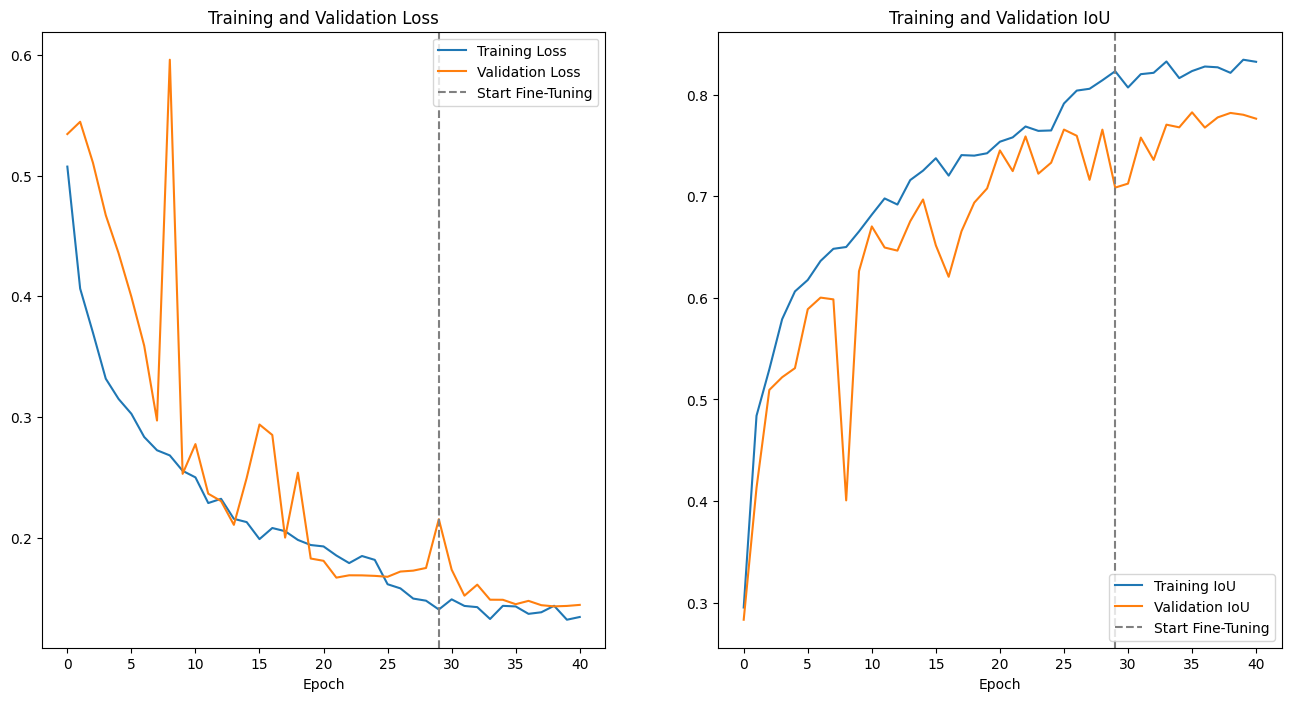

In [40]:
plot_combined_history(history_initial, history_finetune, initial_epochs)

In [41]:
FineTune_model_save_path = '/content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_FineTune2_ResNet50_UNET.keras'
model.save(FineTune_model_save_path)
print(f"FineTune pre-trained model saved to: {FineTune_model_save_path}")

FineTune pre-trained model saved to: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_FineTune2_ResNet50_UNET.keras


Loading model from: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_FineTune2_ResNet50_UNET.keras
✅ Model loaded successfully.

Looking for specified images...
  ✅ Found: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data/images/219.tif
  ✅ Found: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data/images/121.tif
  ✅ Found: /content/drive/MyDrive/Cellula Technology/Water Segmentation/Extracted Dataset/data/images/200.tif


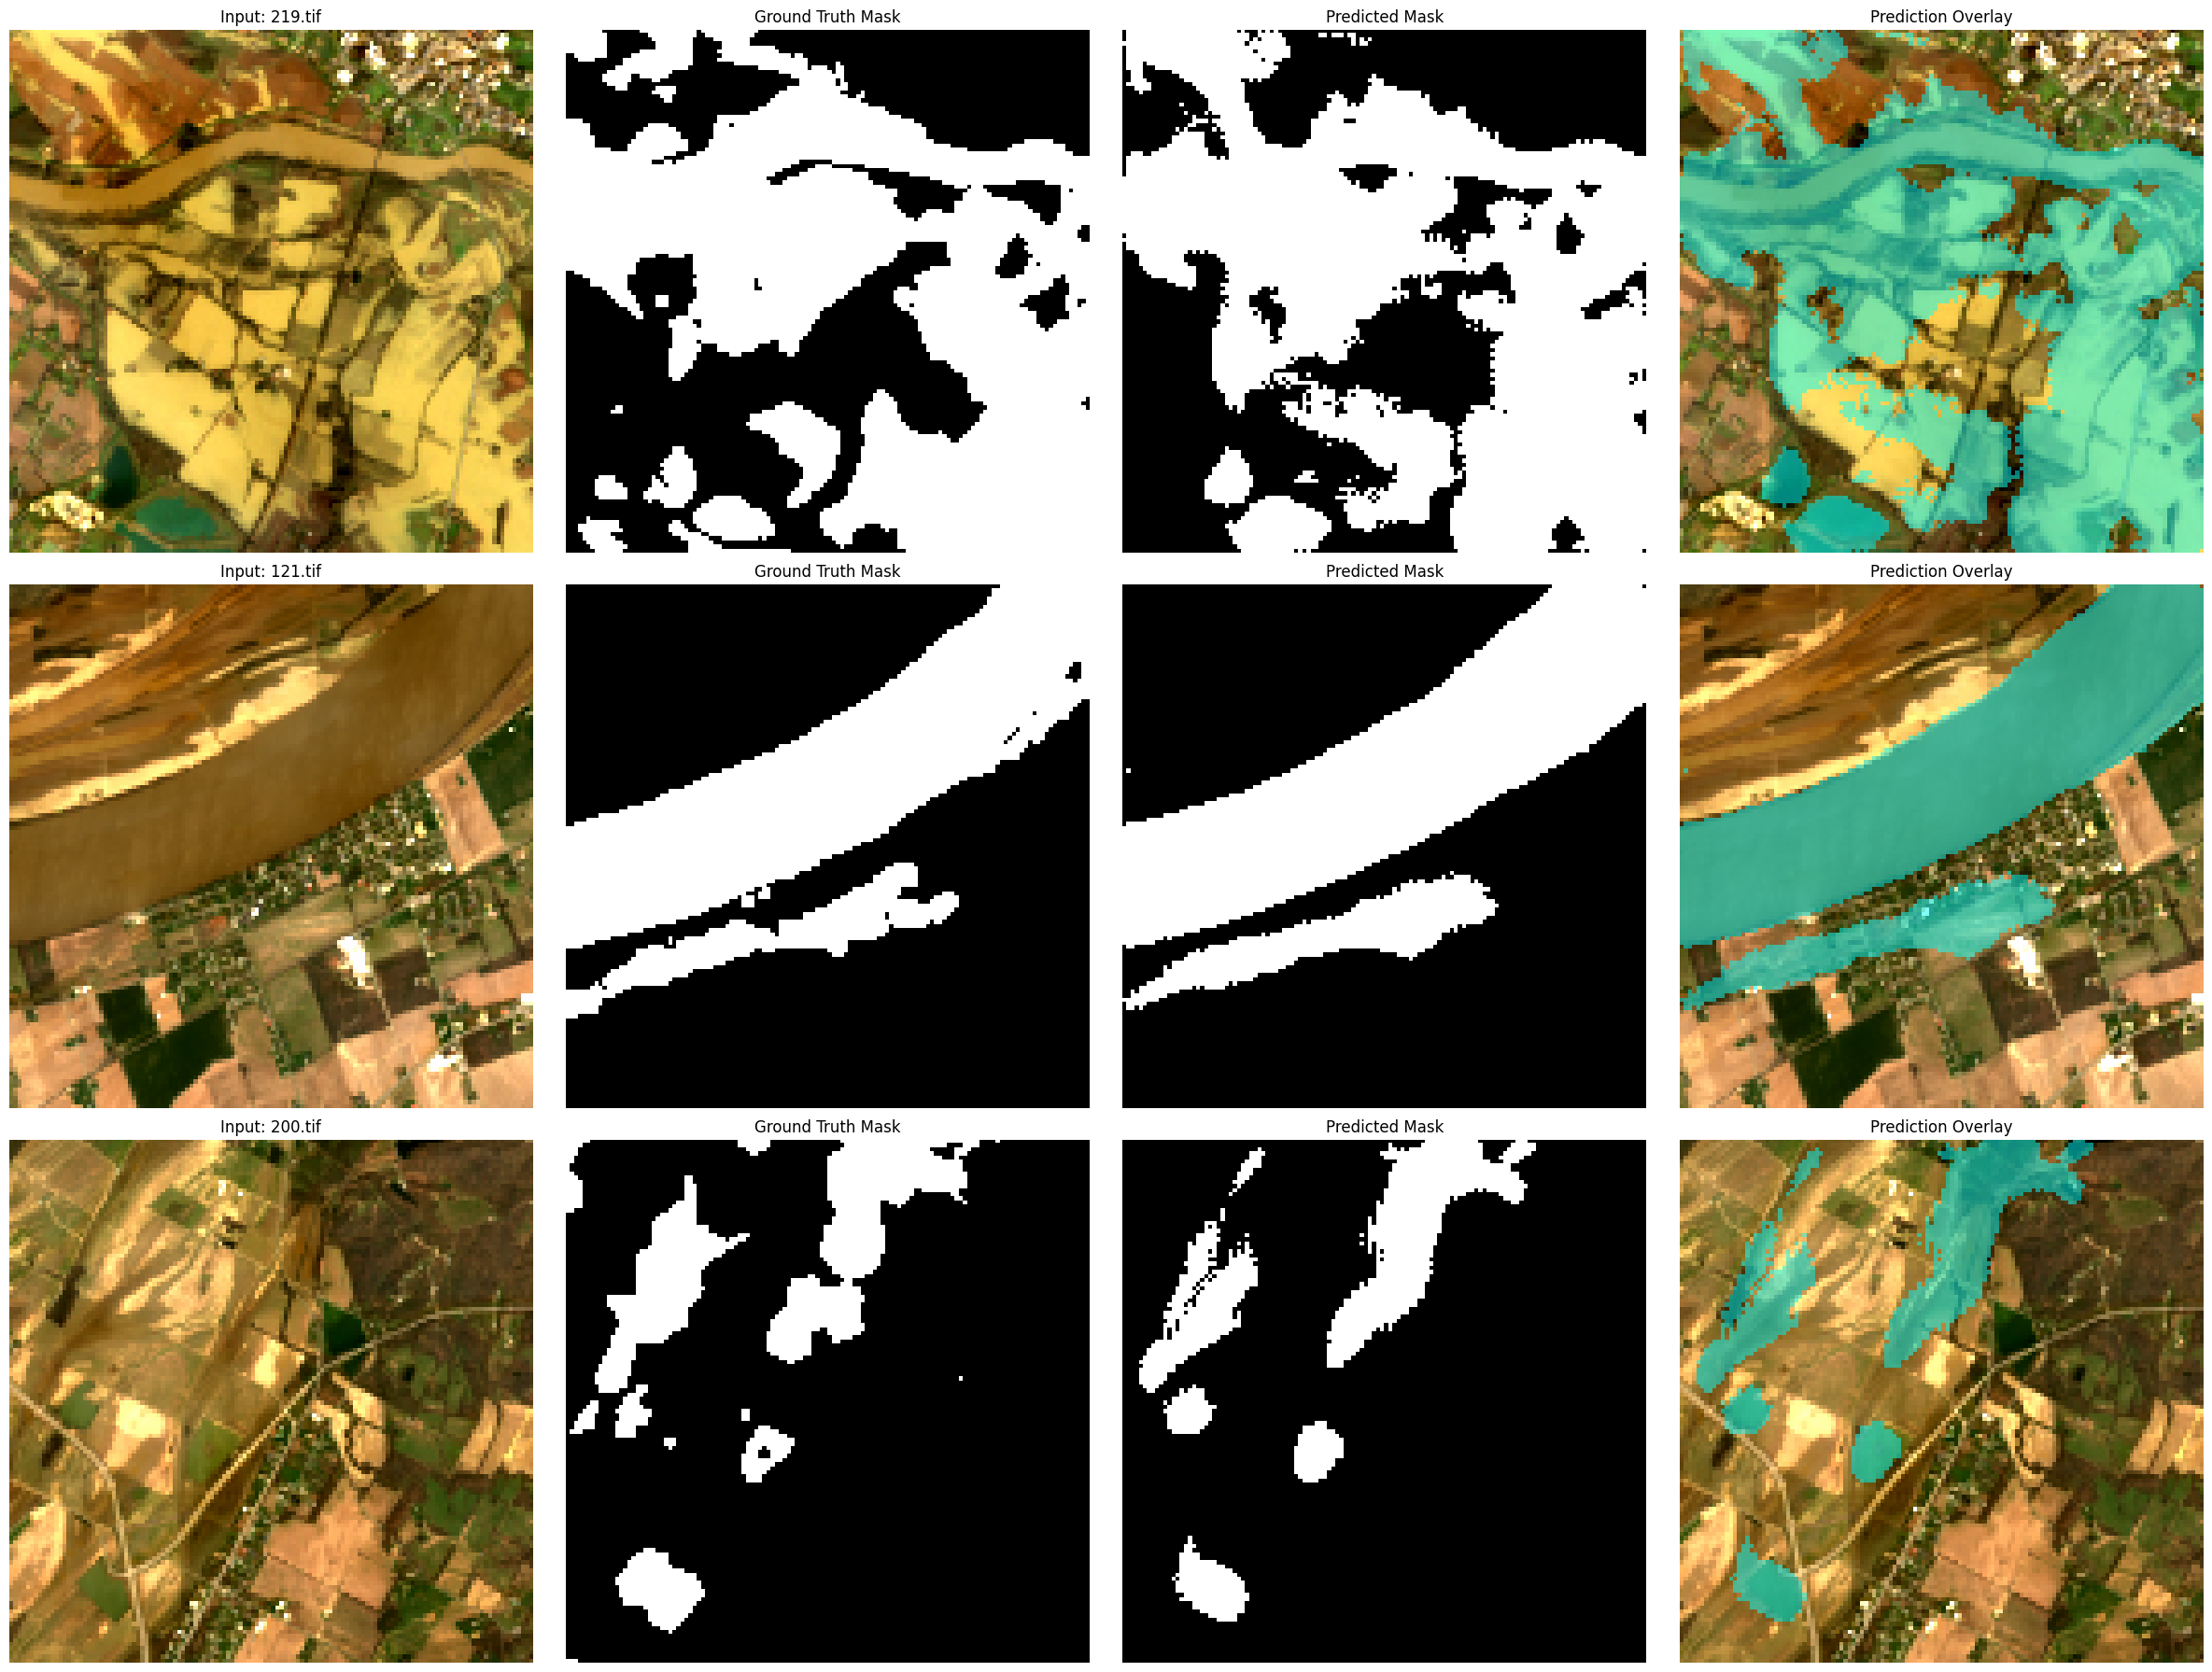

In [21]:
# Load the best-saved model
model_path = '/content/drive/MyDrive/Cellula Technology/Water Segmentation/Water_Segmentation_Model_FineTune2_ResNet50_UNET.keras'
try:
    print(f"Loading model from: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# ---------------------------------------------------------------------------------------------------------------- #

target_basenames = ['219', '121', '200']
test_image_paths = []

print("\nLooking for specified images...")
for basename in target_basenames:
    # Construct the full path to the image
    path = os.path.join(image_dir, f"{basename}.tif")

    # Check if the file actually exists before adding it to our list
    if os.path.exists(path):
        print(f"  ✅ Found: {path}")
        test_image_paths.append(path)
    else:
        print(f"  ⚠️ Warning: Could not find image at {path}. It will be skipped.")

if not test_image_paths:
    print("\n❌ None of the specified images were found. Aborting visualization.")
    # You can stop here if no images were found
    raise FileNotFoundError("Could not find any of the specified images to test.")

num_samples_to_show = len(test_image_paths)

# ---------------------------------------------------------------------------------------------------------------- #

# Create a 4-column subplot for the results
fig, axes = plt.subplots(num_samples_to_show, 4, figsize=(24, 6 * num_samples_to_show))
if num_samples_to_show == 1:
    axes = np.array([axes])

# Loop through each specified test image, predict, and plot

for i, test_image_path in enumerate(test_image_paths):

    # A. Load and preprocess the input image
    input_image = tiff.imread(test_image_path)
    if input_image.shape[0] == IMG_CHANNELS:
        input_image = np.transpose(input_image, (1, 2, 0))

    input_image_for_model = np.expand_dims(input_image.astype(np.float32), axis=0)

    # B. Load the corresponding Ground Truth mask
    ground_truth_path = test_image_path.replace("/images/", "/labels/").replace(".tif", ".png")
    ground_truth_mask = np.array(Image.open(ground_truth_path))

    # C. Make a prediction with the model
    predicted_mask_prob = model.predict(input_image_for_model, verbose=0)

    # D. Post-process the prediction
    threshold = 0.5
    predicted_mask = (predicted_mask_prob[0] > threshold).astype(np.uint8)

    # E. Prepare the True Color image for display
    def normalize_for_display(band_data):
        p2, p98 = np.percentile(band_data, (2, 98))
        clipped_data = np.clip(band_data, p2, p98)
        return (clipped_data - p2) / (p98 - p2 + 1e-8)

    true_color_display = input_image[:, :, [3, 2, 1]].copy()
    true_color_display = normalize_for_display(true_color_display)

    # F. Plot all four results for this sample

    # Column 1: Input Image
    axes[i, 0].imshow(true_color_display)
    axes[i, 0].set_title(f'Input: {os.path.basename(test_image_path)}')
    axes[i, 0].axis('off')

    # Column 2: Ground Truth Mask
    axes[i, 1].imshow(ground_truth_mask, cmap='gray')
    axes[i, 1].set_title('Ground Truth Mask')
    axes[i, 1].axis('off')

    # Column 3: Predicted Mask
    axes[i, 2].imshow(predicted_mask, cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

    # Column 4: Prediction Overlay
    cmap_overlay = ListedColormap(['none', 'cyan'])
    axes[i, 3].imshow(true_color_display)
    axes[i, 3].imshow(predicted_mask, cmap=cmap_overlay, alpha=0.5)
    axes[i, 3].set_title('Prediction Overlay')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()